# Matemáticas aplicadas. Parcial 2

#### Samuel Acosta Aristizábal - 1000900513
#### Manuela Caro Villada - 1000124254
#### Jeronimo Velasquez Escobar - 1000116682

In [45]:
## Se inicialializa el programa y se importan las librerias necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Ejercicio Numero 1

In [46]:
## Se cargan los datos del archivo CSV

data = pd.read_csv('data/datos_ejercicio1.csv')

## Cargar los datos como una matriz con numpy
X = data.to_numpy()

## Creacion de la matriz de similitud
def pairwise_distances(X):
    n = X.shape[0]
    D = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            D[i,j] = np.linalg.norm(X[i] - X[j])
            
    return D
def build_similarity(X, kNN=10, epsilon=1e-5):
    n = X.shape[0]
    distances = pairwise_distances(X)
    
    S = np.zeros((n,n))
    
    for i in range(n):
        idx_sorted = np.argsort(distances[i])
        neighbors = idx_sorted[1:kNN+1]  # ignorar él mismo
        
        for j in neighbors:
            S[i,j] = 1 / (distances[i,j] + epsilon)
    
    # hacerla simétrica
    S = (S + S.T) / 2
    return S
def build_laplacian(S):
    D = np.diag(S.sum(axis=1))
    L = D - S
    return L

S = build_similarity(X, kNN=10)
L = build_laplacian(S)
## Calcular los autovectores y autovalores del Laplaciano
eigenvalues, eigenvectors = np.linalg.eigh(L)
## Ordenar los autovectores y autovalores de menor a mayor
idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

Text(0, 0.5, 'Valor propio')

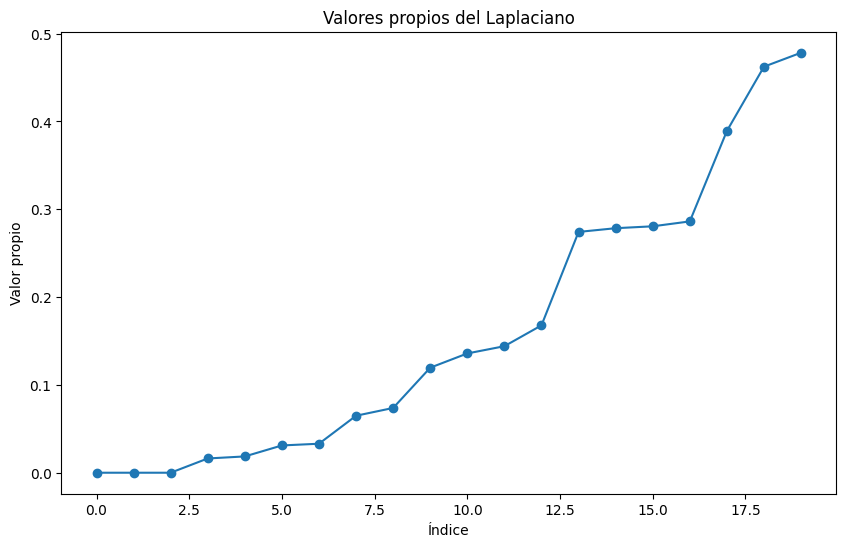

In [47]:
# Se grafican los vlores propios para visualizar el codo
plt.figure(figsize=(10,6))
plt.plot(eigenvalues[:20], marker='o')
plt.title('Valores propios del Laplaciano')
plt.xlabel('Índice')
plt.ylabel('Valor propio')

In [48]:
## Basados en la grafica anterior nos quedamos con k = 13, puesto que es el punto donde se observa un cambio mas significativo en los valores propios
## Aunque 17 esta en consideracion, se opta por 13 para evitar un posible sobreajuste
k = 13

def kmeans(X, k, max_iters=100):
    n, d = X.shape
    
    # Inicialización aleatoria
    centroids = X[np.random.choice(n, k, replace=False)]
    
    for _ in range(max_iters):
        # Asignación
        labels = np.zeros(n)
        for i in range(n):
            distances = [np.linalg.norm(X[i] - c) for c in centroids]
            labels[i] = np.argmin(distances)
        
        # Actualización
        new_centroids = np.array([
            X[labels == j].mean(axis=0) if len(X[labels == j]) > 0 else centroids[j]
            for j in range(k)
        ])
        
        if np.allclose(centroids, new_centroids):
            break
            
        centroids = new_centroids
        
    return labels

# Se seleccionan los k autovectores correspondientes a los k menores autovalores
X_k = eigenvectors[:, :k]
# Se aplica k-means sobre los autovectores seleccionados
labels = kmeans(X_k, k)
labels_original = kmeans(X, k)

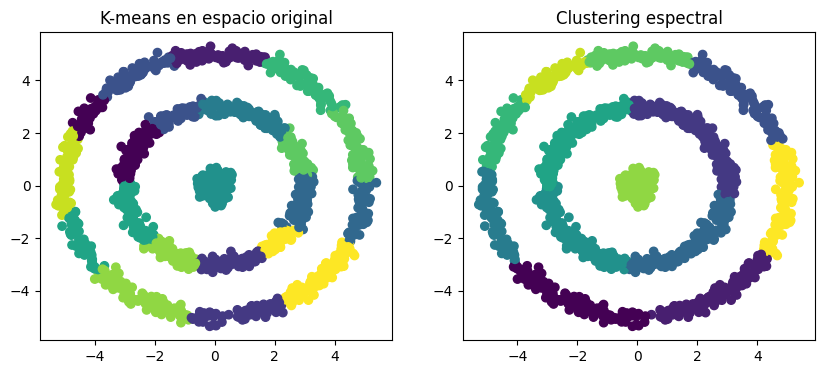

In [49]:
## Comparamos ambos resultados graficamente para visualizar las diferencias entre el clustering en el espacio original y el clustering espectral
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=labels_original)
plt.title("K-means en espacio original")

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=labels)
plt.title("Clustering espectral")

plt.show()

In [50]:
## Creacion de la matriz de similitud con kernel gaussiano
def build_similarity_gaussian(X, kNN=10, sigma=1.0):
    n = X.shape[0]
    distances = pairwise_distances(X)
    S = np.zeros((n,n))
    
    for i in range(n):
        idx_sorted = np.argsort(distances[i])
        neighbors = idx_sorted[1:kNN+1]
        
        for j in neighbors:
            S[i,j] = np.exp(-(distances[i,j]**2)/(2*sigma**2))
    
    S = (S + S.T)/2
    return S

In [51]:
## Repetimos pipelines con la nueva matriz de similitud
S_gaussian = build_similarity_gaussian(X, kNN=10, sigma=1.0)
L_gaussian = build_laplacian(S_gaussian)
eigenvalues_gaussian, eigenvectors_gaussian = np.linalg.eigh(L_gaussian)
idx_gaussian = np.argsort(eigenvalues_gaussian)
eigenvalues_gaussian = eigenvalues_gaussian[idx_gaussian]
eigenvectors_gaussian = eigenvectors_gaussian[:, idx_gaussian]


Text(0, 0.5, 'Valor propio')

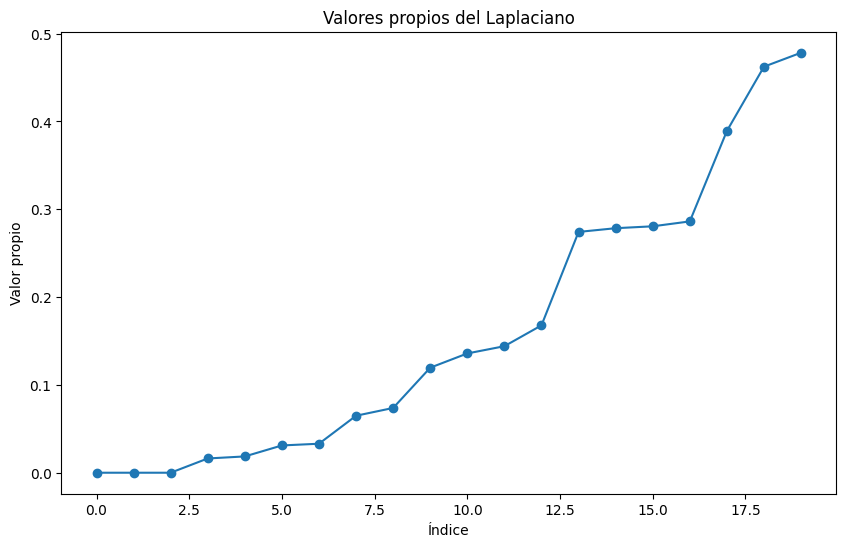

In [52]:
# Se grafican los vlores propios para visualizar el codo
plt.figure(figsize=(10,6))
plt.plot(eigenvalues[:20], marker='o')
plt.title('Valores propios del Laplaciano')
plt.xlabel('Índice')
plt.ylabel('Valor propio')

In [53]:
gaussian_k = 13
X_k_gaussian = eigenvectors_gaussian[:, :gaussian_k]
labels_gaussian = kmeans(X_k_gaussian, gaussian_k)


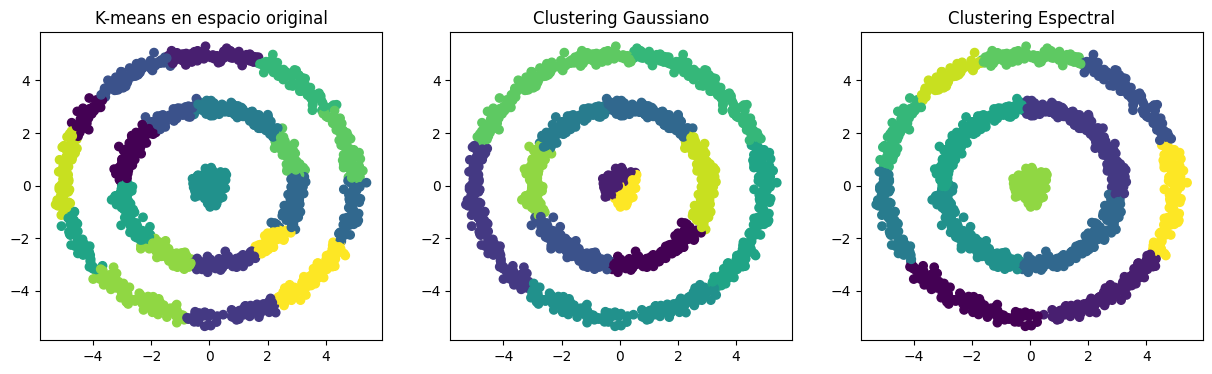

In [54]:
## Comparamos ambos resultados graficamente para visualizar las diferencias entre el clustering en el espacio original y el clustering espectral
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.scatter(X[:,0], X[:,1], c=labels_original)
plt.title("K-means en espacio original")

plt.subplot(1,3,2)
plt.scatter(X[:,0], X[:,1], c=labels_gaussian)
plt.title("Clustering Gaussiano")

plt.subplot(1,3,3)
plt.scatter(X[:,0], X[:,1], c=labels)
plt.title("Clustering Espectral")

plt.show()

### Resultados obtenidos tras realizar el punto numero 1

- El método k-means en el espacio original falla debido a que los clusters no presentan forma convexa. El uso de una matriz de similitud basada en un kernel gaussiano mejora la preservación de la estructura local. Sin embargo, el método espectral logra capturar adecuadamente la estructura topológica del dataset, separando correctamente los anillos concéntricos al proyectar los datos en el subespacio generado por los eigenvectores asociados a los menores eigenvalores del Laplaciano.